<img src="https://cekumagroup.cas.lehigh.edu/sites/cekumagroup.cas2.lehigh.edu/files/image10.jpg "/>

# About the data
*The GroupLens Research Project is a research group in the Department of Computer Science and Engineering at 
*the University of Minnesota. Members of the GroupLens Research Project are involved in many research projects 
*related to the fields of information filtering, collaborative filtering, and recommender systems. 
*he project is led by professors John Riedl and Joseph Konstan. 
*The project began to explore automated collaborative filtering in 1992 but is most well 
*known for its worldwide trial of an automated collaborative filtering system for Usenet news in 1996. 
*Since then the project has expanded its scope to research overall information by filtering solutions, 
*integrating into content-based methods, as well as, improving current collaborative filtering technology.

## Problem Objective :

* Here, we ask you to perform the analysis using the Exploratory Data Analysis technique. 
* You need to find features affecting the ratings of any particular movie and build a model to predict the movie ratings.

### Domain: Entertainment

## Analysis Tasks to be performed:

* Import the three datasets
* Create a new dataset [Master_Data] with the following columns MovieID Title UserID Age Gender Occupation Rating. (Hint: (i) Merge two tables at a time. (ii) Merge the tables using two primary keys MovieID & UserId)
* Explore the datasets using visual representations (graphs or tables), also include your comments on the following:
* User Age Distribution
* User rating of the movie “Toy Story”
* Top 25 movies by viewership rating
* Find the ratings for all the movies reviewed by for a particular user of user id = 2696
* Perform other data analysis 

In [1]:
#--------------------------------------------------
# Import the necessary Libraries for the analysis
#--------------------------------------------------
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
import cufflinks as cf
import matplotlib.lines as lines
import itertools
import xgboost as xgb
import lightgbm as lgbm
import plotly.express as px
import shap
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations
from xgboost import plot_importance, plot_tree
from sklearn.metrics import f1_score,classification_report,accuracy_score, auc
from plotly.offline import init_notebook_mode, iplot 
from IPython.display import display
from itertools import combinations
from collections import Counter
from wordcloud import WordCloud
%matplotlib inline
# Set notebook mode to work in offline
#init_notebook_mode(connected=True)
init_notebook_mode(connected=True)

In [2]:
# Import the necessary files
ratings = pd.read_table('ratings.dat', header = None, sep = '::',
                        names=['UserId', 'MovieID', 'Rating', 'Timestamp'])
users = pd.read_table('users.dat', header = None, sep = '::', 
                      names=['UserId', 'Gender', 'Age', 'Occupation', 'Zip Code'])
movies = pd.read_table('movies.dat', header = None, sep = '::', 
                       names=['MovieID', 'Title', 'Genre'],encoding = "ISO-8859-1") 
# Use this encoding to avoid error encodinh = 'latin-1' also will work

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [3]:
# Check the first few lines

In [4]:
ratings.head()

,UserId,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
users.head()

,UserId,Gender,Age,Occupation,Zip Code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
movies.head()

,MovieID,Title,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Check the shape
print(ratings.shape)
print(users.shape)
print(movies.shape)

(1000209, 4)
(6040, 5)
(3883, 3)


In [8]:
#Starting merging the files: Use 'MovieID' as a common key
merge_ratings_movies = pd.merge(ratings, movies, on='MovieID', how='outer')

In [9]:
merge_ratings_movies.head()

,UserId,MovieID,Rating,Timestamp,Title,Genre
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama
1,2.0,1193,5.0,978298413.0,One Flew Over the Cuckoo's Nest (1975),Drama
2,12.0,1193,4.0,978220179.0,One Flew Over the Cuckoo's Nest (1975),Drama
3,15.0,1193,4.0,978199279.0,One Flew Over the Cuckoo's Nest (1975),Drama
4,17.0,1193,5.0,978158471.0,One Flew Over the Cuckoo's Nest (1975),Drama


In [10]:
merge_ratings_movies.shape

(1000386, 6)

In [11]:
# Lastly, merge the above with the users data using "UserID" as a common key
Master_Data = pd.merge(merge_ratings_movies, users, on='UserId', how='outer')

In [12]:
Master_Data.head()

,UserId,MovieID,Rating,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama,F,1.0,10.0,48067
1,1.0,661,3.0,978302109.0,James and the Giant Peach (1996),Animation|Children's|Musical,F,1.0,10.0,48067
2,1.0,914,3.0,978301968.0,My Fair Lady (1964),Musical|Romance,F,1.0,10.0,48067
3,1.0,3408,4.0,978300275.0,Erin Brockovich (2000),Drama,F,1.0,10.0,48067
4,1.0,2355,5.0,978824291.0,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1.0,10.0,48067


In [13]:
Master_Data.shape

(1000386, 10)

In [14]:
Master_Data.describe()

,UserId,MovieID,Rating,Timestamp,Age,Occupation
count,1.000209e+06,1.000386e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865526e+03,3.581564e+00,9.722437e+08,2.973831e+01,8.036138e+00
std,1.728413e+03,1.096030e+03,1.117102e+00,1.215256e+07,1.175198e+01,6.531336e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08,1.000000e+00,0.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08,2.500000e+01,2.000000e+00
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08,2.500000e+01,7.000000e+00
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08,3.500000e+01,1.400000e+01
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09,5.600000e+01,2.000000e+01


# Expore the data

In [15]:
# Age distribution
age_dist = Master_Data.groupby('Age').size()

In [16]:
age_dist

Age
1.0      27211
18.0    183536
25.0    395556
35.0    199003
45.0     83633
50.0     72490
56.0     38780
dtype: int64

Text(0.5, 0, 'Age')

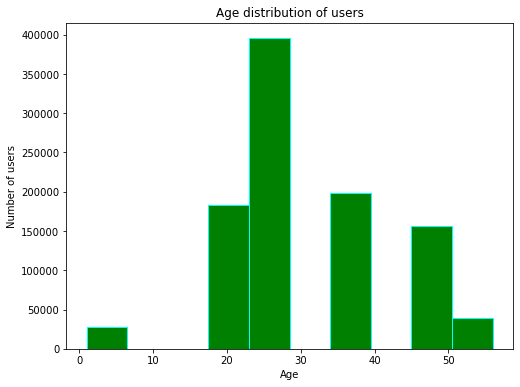

In [17]:
plt.figure(figsize=(8,6))
plt.hist(Master_Data.Age,color='Green',edgecolor='Cyan',bins=10)
plt.title('Age distribution of users')
plt.ylabel('Number of users')
plt.xlabel('Age')

In [18]:
# Plot the average age of men and women giving ratings
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)
#plt.rcParams["figure.figsize"] = (12, 8)
#plt.rcParams['axes.titlesize'] = 16
fig_array = []
fig1 = pd.pivot_table(data = Master_Data[Master_Data['Gender'] == 'M'], index = 'Rating', values = 'Age',
                      aggfunc = 'mean').figure(kind = 'line', color = 'red', xTitle = 'Rating',
                                               yTitle = 'Avg. Age',asFigure = True)
fig_array.append(fig1)

fig2 = pd.pivot_table(data = Master_Data[Master_Data['Gender'] == 'F'], index = 'Rating',values = 'Age', 
                      aggfunc = 'mean').figure(kind = 'line', color = 'teal', xTitle = 'Rating',
                                               yTitle = 'Avg. Age')
fig_array.append(fig2)

fig = cf.subplots(fig_array, shape = (1, 2), subplot_titles = ['Avg. Age of Men giving Ratings', 
                                                               'Avg. Age of Women giving Ratings'])
fig['layout'].update(showlegend = False)
iplot(fig)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='Age', ylabel='Density'>

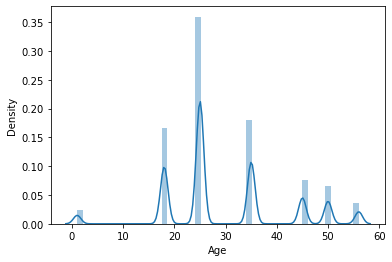

In [19]:
sns.distplot(Master_Data['Age'],hist = True, kde = True) #We can also use seaborn

In [20]:
# From above, we see that most viewers are 25 years old

In [21]:
# Using movie rating
movie_rating = Master_Data.groupby('Rating').size()

In [22]:
movie_rating

Rating
1.0     56174
2.0    107557
3.0    261197
4.0    348971
5.0    226310
dtype: int64

Text(0.5, 0, 'Rating')

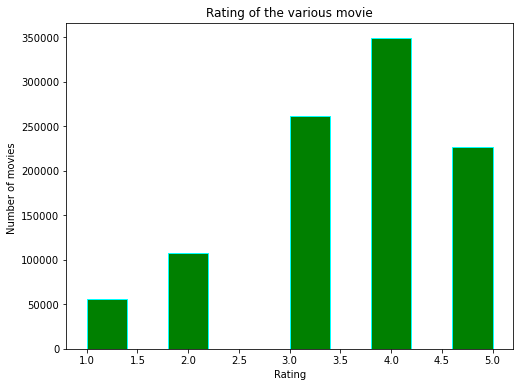

In [23]:
plt.figure(figsize=(8,6))
plt.hist(Master_Data.Rating,color='Green',edgecolor='Cyan',bins=10)
plt.title('Rating of the various movie')
plt.ylabel('Number of movies ')
plt.xlabel('Rating')

In [24]:
# From above, we see that 4.0 is the highest of the ratings

Text(0.5, 1.0, 'Plot of the movie ratings')

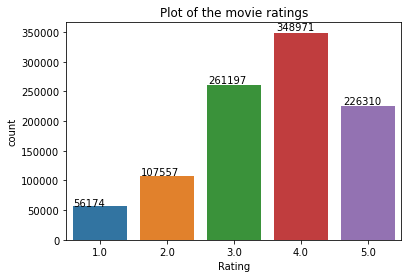

In [25]:
# We use seaborn as
ax = sns.countplot(data=Master_Data,x='Rating')
for p in ax.patches:
    ax.annotate(str(p.get_height()),  (p.get_x()* 1.01, p.get_height()*1.01) )
plt.title('Plot of the movie ratings')

In [26]:
#Check viewership by gender
gender_group = Master_Data.groupby('Gender').size()
gender_group

Gender
F    246440
M    753769
dtype: int64

In [27]:
#Info based on gender 
Master_Data[Master_Data['Gender']=='F']

,UserId,MovieID,Rating,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama,F,1.0,10.0,48067
1,1.0,661,3.0,978302109.0,James and the Giant Peach (1996),Animation|Children's|Musical,F,1.0,10.0,48067
2,1.0,914,3.0,978301968.0,My Fair Lady (1964),Musical|Romance,F,1.0,10.0,48067
3,1.0,3408,4.0,978300275.0,Erin Brockovich (2000),Drama,F,1.0,10.0,48067
4,1.0,2355,5.0,978824291.0,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1.0,10.0,48067
...,...,...,...,...,...,...,...,...,...,...
1000030,1615.0,2769,3.0,974729219.0,"Yards, The (1999)",Crime|Mystery,F,45.0,7.0,10022
1000031,1615.0,117,3.0,974729037.0,"Young Poisoner's Handbook, The (1995)",Crime,F,45.0,7.0,10022
1000032,1615.0,3950,3.0,974729219.0,Tigerland (2000),Drama,F,45.0,7.0,10022
1000033,1615.0,3951,3.0,974729219.0,Two Family House (2000),Drama,F,45.0,7.0,10022


In [28]:
Master_Data[Master_Data['Gender']=='M']

,UserId,MovieID,Rating,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code
53,2.0,1193,5.0,978298413.0,One Flew Over the Cuckoo's Nest (1975),Drama,M,56.0,16.0,70072
54,2.0,3105,4.0,978298673.0,Awakenings (1990),Drama,M,56.0,16.0,70072
55,2.0,2321,3.0,978299666.0,Pleasantville (1998),Comedy,M,56.0,16.0,70072
56,2.0,1962,5.0,978298813.0,Driving Miss Daisy (1989),Drama,M,56.0,16.0,70072
57,2.0,1207,4.0,978298478.0,To Kill a Mockingbird (1962),Drama,M,56.0,16.0,70072
...,...,...,...,...,...,...,...,...,...,...
1000204,4211.0,3791,2.0,965319075.0,Footloose (1984),Drama,M,45.0,5.0,77662
1000205,4211.0,3806,3.0,965319138.0,MacKenna's Gold (1969),Western,M,45.0,5.0,77662
1000206,4211.0,3840,4.0,965319197.0,Pumpkinhead (1988),Horror,M,45.0,5.0,77662
1000207,4211.0,3766,2.0,965319138.0,Missing in Action (1984),Action|War,M,45.0,5.0,77662


In [29]:
Master_Data[Master_Data['Gender']=='F'].describe()

,UserId,MovieID,Rating,Timestamp,Age,Occupation
count,246440.000000,246440.000000,246440.000000,2.464400e+05,246440.000000,246440.000000
mean,3130.437380,1824.086212,3.620366,9.724327e+08,29.803855,6.722837
std,1791.592052,1096.602789,1.111228,1.347125e+07,12.144116,6.229740
min,1.000000,1.000000,1.000000,9.567052e+08,1.000000,0.000000
25%,1560.000000,934.000000,3.000000,9.645518e+08,25.000000,1.000000
50%,3174.000000,1732.000000,4.000000,9.723956e+08,25.000000,4.000000
75%,4771.000000,2734.000000,4.000000,9.752104e+08,35.000000,11.000000
max,6039.000000,3952.000000,5.000000,1.046352e+09,56.000000,20.000000


In [30]:
Master_Data[Master_Data['Gender']=='M'].describe()

,UserId,MovieID,Rating,Timestamp,Age,Occupation
count,753769.000000,753769.000000,753769.000000,7.537690e+05,753769.000000,753769.000000
mean,2989.880830,1879.092918,3.568879,9.721819e+08,29.716885,8.465514
std,1705.824544,1095.517379,1.118724,1.168854e+07,11.620835,6.570269
min,2.000000,1.000000,1.000000,9.567039e+08,1.000000,0.000000
25%,1501.000000,1051.000000,3.000000,9.653325e+08,25.000000,3.000000
50%,3032.000000,1882.000000,4.000000,9.731500e+08,25.000000,7.000000
75%,4403.000000,2791.000000,4.000000,9.752282e+08,35.000000,15.000000
max,6040.000000,3952.000000,5.000000,1.046455e+09,56.000000,20.000000


<AxesSubplot:xlabel='Gender'>

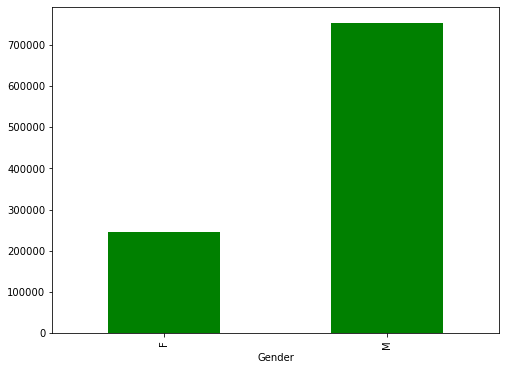

In [31]:
#Let's plot it 
plt.figure(figsize=(8,6))
gender_group.plot(kind='bar',color='Green')

Text(0.5, 1.0, 'Plot of the Gender')

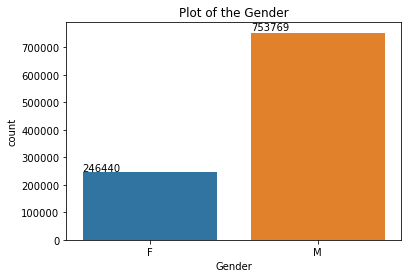

In [32]:
# We use seaborn as
ax = sns.countplot(data=Master_Data,x='Gender')
for p in ax.patches:
    ax.annotate(str(p.get_height()),  (p.get_x()* 1.01, p.get_height()*1.01) )
plt.title('Plot of the Gender')

## Number of movies released per year

In [33]:
getyear = re.compile(r"\((\d+)\)")
Master_Data['Release Year'] = Master_Data['Title'].apply(lambda x: getyear.findall(x)[0])
Master_Data.head()

,UserId,MovieID,Rating,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code,Release Year
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama,F,1.0,10.0,48067,1975
1,1.0,661,3.0,978302109.0,James and the Giant Peach (1996),Animation|Children's|Musical,F,1.0,10.0,48067,1996
2,1.0,914,3.0,978301968.0,My Fair Lady (1964),Musical|Romance,F,1.0,10.0,48067,1964
3,1.0,3408,4.0,978300275.0,Erin Brockovich (2000),Drama,F,1.0,10.0,48067,2000
4,1.0,2355,5.0,978824291.0,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1.0,10.0,48067,1998


In [34]:

#Plot it here
Master_Data.groupby('Release Year')['Title'].nunique().sort_values().iplot(kind = 'bar',
                                                                     color = 'purple',
                                                                     title = 'Number of Movie release per year', 
                                                                     xTitle = 'Release Year', yTitle = 'Number of movies')

## Number of movies released by Genre

In [35]:
Master_Data.groupby('Genre')['Title'].nunique().sort_values().iplot(kind = 'bar', 
                                                       color = 'green', 
                                                       title = 'Movie release by Genre - Main', 
                                                        xTitle = 'Genre',
                                                        yTitle = 'Count')

In [36]:
# To make it easier, let's split the genre more uniquely into subgroups, let's do the following
df = Master_Data
genre = pd.DataFrame(df['Genre'].str.split('|', expand = True))
genre.columns = ['Genre_1', 'Genre_2', 'Genre_3', 'Genre_4', 'Genre_5', 'Genre_6']
df = df.join(genre)
df.head()

,UserId,MovieID,Rating,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code,Release Year,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama,F,1.0,10.0,48067,1975,Drama,None,None,None,None,None
1,1.0,661,3.0,978302109.0,James and the Giant Peach (1996),Animation|Children's|Musical,F,1.0,10.0,48067,1996,Animation,Children's,Musical,None,None,None
2,1.0,914,3.0,978301968.0,My Fair Lady (1964),Musical|Romance,F,1.0,10.0,48067,1964,Musical,Romance,None,None,None,None
3,1.0,3408,4.0,978300275.0,Erin Brockovich (2000),Drama,F,1.0,10.0,48067,2000,Drama,None,None,None,None,None
4,1.0,2355,5.0,978824291.0,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1.0,10.0,48067,1998,Animation,Children's,Comedy,None,None,None


In [37]:
df.groupby('Genre_1')['Title'].nunique().sort_values().iplot(kind = 'bar', 
                                                       color = 'green', 
                                                       title = 'Movie release by Genre - Main', 
                                                        xTitle = 'Genre',
                                                        yTitle = 'Count')

In [38]:
df.groupby('Genre_4')['Title'].nunique().sort_values().iplot(kind = 'bar', 
                                                       color = 'orange', 
                                                       title = 'Movie release by Genre - Main', 
                                                        xTitle = 'Genre',
                                                        yTitle = 'Count')
# And so on.

In [39]:
# Note, we can cobine any or all of the sub-genres
df.groupby(['Genre_1','Genre_4'])['Title'].nunique().sort_values().iplot(kind = 'bar', 
                                                       color = 'blue', 
                                                       title = 'Movie release by Genre - Main', 
                                                        xTitle = 'Genre1-Genre4',
                                                        yTitle = 'Count')
# And so on.

In [40]:
# We can rotate it
df.groupby(['Genre_1','Genre_4'])['Title'].nunique().sort_values().iplot(kind = 'bar', 
                                                       color = 'blue', 
                                                       title = 'Movie release by Genre - Main', 
                                                        xTitle = 'Count',orientation = 'h',
                                                        yTitle = 'Genre1-Genre4')

In [41]:
#Check ratings based on genre and list with respect to gender

Master_Data.pivot_table('Rating', index = 'Genre', columns = 'Gender')

Gender,F,M
Genre,,
Action,3.367474,3.352991
Action|Adventure,3.701213,3.671115
Action|Adventure|Animation,3.843750,4.217082
Action|Adventure|Animation|Children's|Fantasy,3.146341,2.510638
Action|Adventure|Animation|Horror|Sci-Fi,3.422535,3.563071
...,...,...
Sci-Fi|Thriller|War,3.450000,3.437500
Sci-Fi|War,4.376623,4.464789
Thriller,3.563776,3.553364


In [42]:
# Check ratings per year 
ratings_per_year = df.groupby(['Rating','Release Year'])['Title']

In [43]:
fig_array = []
fig1 = ratings_per_year.nunique()[2.0][:].sort_values().figure(kind = 'bar', color = 'purple')
fig_array.append(fig1)

fig2 = ratings_per_year.nunique()[3.0][:].sort_values().figure(kind = 'bar', color = 'green')
fig_array.append(fig2)

fig3 = ratings_per_year.nunique()[4.0][:].sort_values().figure(kind = 'bar', color = 'orange')
fig_array.append(fig3)

fig4 = ratings_per_year.nunique()[5.0][:].sort_values().figure(kind = 'bar', color = 'turquoise')
fig_array.append(fig4)

fig = cf.subplots(fig_array, shape = (2, 2), subplot_titles = ['Movies released per year with rating of 2.0',
                                                               'Movies released per year with rating of 3.0',
                                                               'Movies released per year with rating of 4.0',
                                                               'Movies released per year with rating of 5.0'])
fig['layout'].update(showlegend = False)
iplot(fig)

## Let us check ratings and plot it for all the movies for all years

In [44]:
def ViewRatings(year = None):
    colors = ['green', 'purple', 'blue', 'red', 'orange']
    ratings_list = [5.0, 4.0, 3.0, 2.0, 1.0]
    if year:
        df_year = Master_Data[Master_Data['Release Year'] == year]
    else:
        df_year = Master_Data  #Note you can use df here since it is the same as our Master_Data
        year = 'dataset'
    fig_array = []
    title_list = []
    for i, r in enumerate(ratings_list):
        # Obtain movies with rating
        fig = df_year[df_year['Rating'] == r]['Title'].value_counts()[:50].figure(kind = 'bar', color = colors[i], 
                                                                                 orientation = 'h')
        fig_array.append(fig)
        title_list.append(f"Top 50 movies of {year} with Rating {r}")

    fig = cf.subplots(fig_array, shape = (5, 1),
                      subplot_titles = title_list, vertical_spacing = 0.05)
    
    # Adjust height and add overall title
    fig['layout']['height'] = len(ratings_list) * 250
    #fig['layout']['width'] = 
    fig['layout']['title'] = 'Movie Rating by Users'
    
    fig['layout'].update(showlegend = False)
    iplot(fig)

In [45]:
ViewRatings()

# We can check users rating based on years.

In [46]:
# We can use our function above
ViewRatings('1999')

## One movie might have more than one rating. Let's check

In [47]:
def ViewRating_2(year = None):
    colors = ['green', 'purple', 'blue', 'red', 'orange', 'turquoise', 'grey']
    ratings_list = [5.0, 4.0, 3.0, 2.0, 1.0]
    rating_combo = list(combinations(ratings_list, 2))
    if year:
        df_year = df[df['Release Year'] == year]
    else:
        df_year = df
        year = 'dataset'
    fig_array = []
    title_list = []
    for i, r in enumerate(rating_combo):
        #Movies with rating
        fig = df_year[(df_year['Rating'] == r[0]) | (df_year['Rating'] == r[1])]['Title'].value_counts()[:50].figure(kind = 'bar', 
                                                                                                                     color = np.random.choice(colors, 1)[0], 
                                                                                                                     orientation = 'h')
        fig_array.append(fig)
        title_list.append(f"Top 50 movies of {year} with Ratings {r[0]}, {r[1]}")

    fig = cf.subplots(fig_array, shape = (len(rating_combo), 1),
                      subplot_titles = title_list, vertical_spacing = 0.03)
    
    # Adjust height and add overall title
    fig['layout']['height'] = len(rating_combo) * 200
    #fig['layout']['width'] = 
    fig['layout']['title'] = 'Movie with 2 Ratings by Users'
    
    fig['layout'].update(showlegend = False)
    iplot(fig)

In [48]:
ViewRating_2()

In [49]:
# Then for a specific year
ViewRating_2('1999')

## Movies with the highest number of ratings

In [50]:
# Here we can choose the top 20 movies
df['Title'].value_counts()[:20].iplot(kind = 'bar', 
                                        color = 'green', 
                                        orientation = 'h',
                                        title = 'Movies with highest number of Rating', 
                                        xTitle = 'Num of Rating', 
                                        yTitle = 'Movie Title')

## Let's regroup the ages and determine the age group that watches more movies

In [51]:
age_group = {1: 'Under 18', 18: '18 - 24', 25: '25 - 34', 35: '35 - 44', 
             45: '45 - 49', 50: '50 - 55', 56: 'Senior Citizens'}
df['Age'] = df['Age'].map(age_group)

In [52]:
age_count = df.groupby('Age')['Title'].count()
age_count.iplot(kind = 'bar', 
               xTitle = 'Age group',
               yTitle = 'Number of movies watched',
               title = 'Age group with the number of movies')

## Plot word cloud of the age per viewership

In [53]:
age_title = df.groupby('Age')['Title'].unique()

In [54]:
def plot_wordcloud(data, text = None):
    #all_words = [word for each in data for word in each.split(' ')]
    word_freq = Counter(data)

    wordcloud = WordCloud(width = 900,
                          height = 500,
                          max_words = 200,
                          max_font_size = 100,
                          relative_scaling = 0.5,
                          background_color = "rgba(255, 255, 255, 0)", 
                          mode = "RGBA",
                          normalize_plurals = True).generate_from_frequencies(word_freq)
    plt.figure(figsize = (18, 16))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(text, fontsize = 20, color = 'gray', y = 1.05)
    plt.axis("off")
    plt.show()

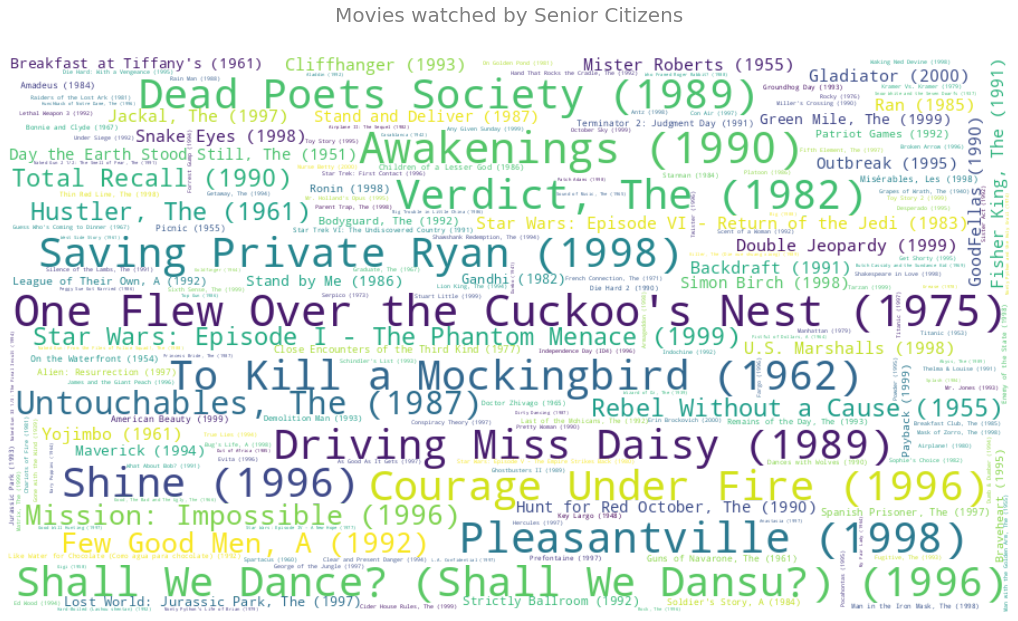

In [55]:
plot_wordcloud(age_title['Senior Citizens'], text='Movies watched by Senior Citizens')

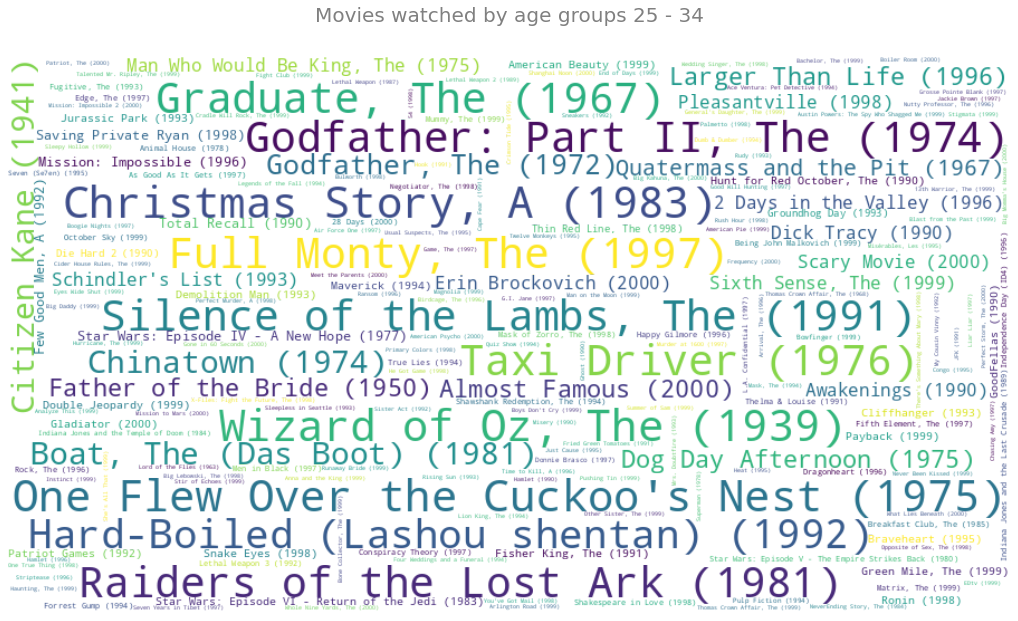

In [56]:
plot_wordcloud(age_title['25 - 34'], text='Movies watched by age groups 25 - 34')

# We can plot top 50 users using the UserID

In [57]:
fig = px.bar(x = df['UserId'].value_counts().index[:50].astype(str), y = df['UserId'].value_counts().values[:50], 
            labels = {'x': 'UserID', 'y': 'Number of movies watched'}, 
             title = 'Top 50 users with the number of movies watched'
            )
fig.show()

## In the problem, we are given the occupation integers. Let's map it and plot

In [58]:
occupation_map = {0: "other",
1: "academic/educator",
2: "artist",
3: "clerical/admin",
4: "college/grad student",
5: "customer service",
6: "doctor/health care",
7: "executive/managerial",
8: "farmer",
9: "homemaker",
10: "K-12 student",
11: "lawyer",
12: "programmer",
13: "retired",
14: "sales/marketing",
15: "scientist",
16: "self-employed",
17: "technician/engineer",
18: "tradesman/craftsman",
19: "unemployed",
20: "writer"}

In [59]:
df['Occupation'] = df['Occupation'].map(occupation_map)

In [60]:
occupation_count = df['Occupation'].value_counts()
occupation_count.iplot(kind = 'bar', xTitle = "Occuptation", 
                      yTitle = 'Number of movies wathced', 
                      title = 'Distribution of the number of movies watched per occupation')

# Explore other group

In [61]:
df.groupby('Occupation')['Age'].unique()

Occupation
K-12 student            [Under 18, 18 - 24, 35 - 44, Senior Citizens, ...
academic/educator       [50 - 55, 25 - 34, Senior Citizens, 45 - 49, 1...
artist                  [25 - 34, 18 - 24, 50 - 55, 35 - 44, Senior Ci...
clerical/admin          [18 - 24, 45 - 49, 35 - 44, 25 - 34, Senior Ci...
college/grad student    [18 - 24, 25 - 34, 35 - 44, 50 - 55, Under 18,...
customer service        [25 - 34, 35 - 44, 45 - 49, 18 - 24, 50 - 55, ...
doctor/health care      [50 - 55, 35 - 44, 25 - 34, 45 - 49, Senior Ci...
executive/managerial    [25 - 34, 35 - 44, 50 - 55, 18 - 24, Senior Ci...
farmer                  [25 - 34, 45 - 49, Under 18, Senior Citizens, ...
homemaker               [Senior Citizens, 35 - 44, 45 - 49, 50 - 55, 2...
lawyer                  [25 - 34, 35 - 44, 50 - 55, 18 - 24, 45 - 49, ...
other                   [25 - 34, 45 - 49, 35 - 44, 18 - 24, Senior Ci...
programmer              [25 - 34, 18 - 24, 35 - 44, 45 - 49, Senior Ci...
retired                 [45

In [62]:
genre_by_age = df.groupby('Age')['Genre'].unique()

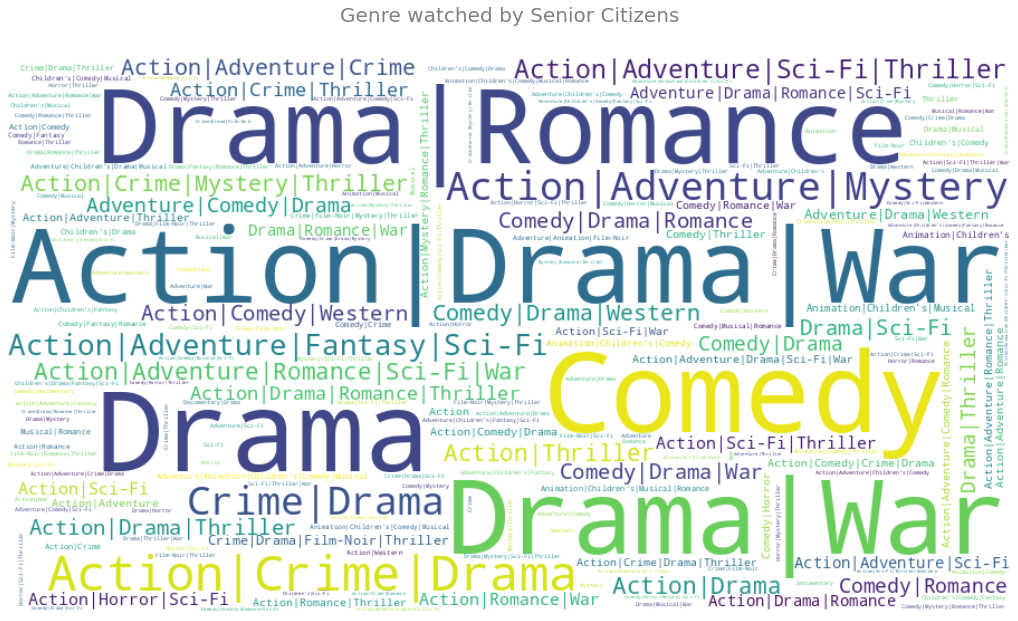

In [63]:
plot_wordcloud(genre_by_age['Senior Citizens'], text='Genre watched by Senior Citizens')

## User rating of the movie “Toy Story”

In [64]:
toy_story_data = Master_Data.loc[Master_Data['Title'] == 'Toy Story (1995)']
toy_story_data.head(10)

,UserId,MovieID,Rating,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code,Release Year
40,1.0,1,5.0,978824268.0,Toy Story (1995),Animation|Children's|Comedy,F,1.0,10.0,48067,1995
634,18.0,1,4.0,978154768.0,Toy Story (1995),Animation|Children's|Comedy,F,18.0,3.0,95825,1995
938,19.0,1,5.0,978555994.0,Toy Story (1995),Animation|Children's|Comedy,M,1.0,10.0,48073,1995
1323,28.0,1,3.0,978985309.0,Toy Story (1995),Animation|Children's|Comedy,F,25.0,1.0,14607,1995
2118,44.0,1,5.0,978019369.0,Toy Story (1995),Animation|Children's|Comedy,M,45.0,17.0,98052,1995
2347,48.0,1,4.0,977975909.0,Toy Story (1995),Animation|Children's|Comedy,M,25.0,4.0,92107,1995
2928,49.0,1,5.0,977972501.0,Toy Story (1995),Animation|Children's|Comedy,M,18.0,12.0,77084,1995
4908,80.0,1,3.0,977786904.0,Toy Story (1995),Animation|Children's|Comedy,M,56.0,1.0,49327,1995
5230,96.0,1,4.0,980563195.0,Toy Story (1995),Animation|Children's|Comedy,F,25.0,16.0,78028,1995
5311,99.0,1,3.0,982873678.0,Toy Story (1995),Animation|Children's|Comedy,F,1.0,10.0,19390,1995


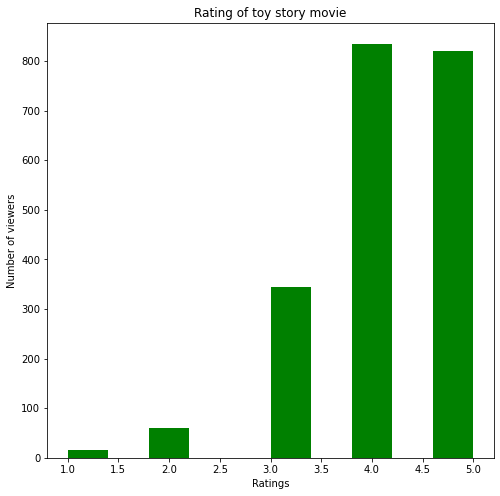

In [65]:
# Visualize the data based on the title Toy Story
plt.figure(figsize=(8,8))
plt.hist(x=toy_story_data['Rating'], color='Green')
plt.title('Rating of toy story movie')
plt.ylabel('Number of viewers')
plt.xlabel('Ratings');

In [66]:
'''
We can conclude that the movie toy story has top ratings. 
The highest of 4.0 with 5.0 follwing closely.
'''

'\nWe can conclude that the movie toy story has top ratings. \nThe highest of 4.0 with 5.0 follwing closely.\n'

Age
1.0     112
18.0    448
25.0    790
35.0    423
45.0    143
50.0    108
56.0     53
dtype: int64


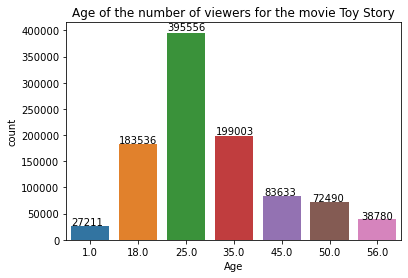

In [67]:
# Still check this
print(toy_story_data.groupby('Age').size())
# Now plot it
toy_story_data1 = Master_Data.loc[Master_Data['Title'] == 'Toy Story (1995)'].all()
ax = sns.countplot(x=Master_Data['Age'] ,data=toy_story_data1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()*1.01, p.get_height()*1.01)  )
    plt.title('Age of the number of viewers for the movie Toy Story')

In [68]:
# Check top 25 movies

In [69]:
movie_rating = Master_Data.groupby(['MovieID'], as_index=False)
average_movie_ratings = movie_rating.agg({'Rating':'mean'})
top_25_movies = average_movie_ratings.sort_values('Rating', ascending=False).head(25)
top_25_movies

,MovieID,Rating
977,989,5.000000
3811,3881,5.000000
1762,1830,5.000000
3313,3382,5.000000
777,787,5.000000
3211,3280,5.000000
3538,3607,5.000000
3164,3233,5.000000
3103,3172,5.000000
3587,3656,5.000000


In [70]:
top_25_view = pd.merge(top_25_movies, Master_Data, how='outer', left_on=['MovieID'], right_on=['MovieID'])
top_25_view.head(25)

,MovieID,Rating_x,UserId,Rating_y,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code,Release Year
0,989,5.00,1915.0,5.0,9.746939e+08,Schlafes Bruder (Brother of Sleep) (1995),Drama,M,50.0,13.0,01938,1995
1,3881,5.00,2885.0,5.0,9.724529e+08,Bittersweet Motel (2000),Documentary,F,18.0,1.0,80302,2000
2,1830,5.00,2869.0,5.0,9.724390e+08,Follow the Bitch (1998),Comedy,M,50.0,17.0,07650,1998
3,3382,5.00,5334.0,5.0,9.607962e+08,Song of Freedom (1936),Drama,F,56.0,13.0,46140,1936
4,787,5.00,2825.0,5.0,9.726102e+08,"Gate of Heavenly Peace, The (1995)",Documentary,F,25.0,20.0,94014,1995
5,787,5.00,149.0,5.0,9.773257e+08,"Gate of Heavenly Peace, The (1995)",Documentary,M,25.0,1.0,29205,1995
6,787,5.00,2872.0,5.0,9.724236e+08,"Gate of Heavenly Peace, The (1995)",Documentary,M,25.0,20.0,94014,1995
7,3280,5.00,46.0,5.0,9.779795e+08,"Baby, The (1973)",Horror,M,18.0,19.0,75602,1973
8,3607,5.00,5851.0,5.0,9.577566e+08,One Little Indian (1973),Comedy|Drama|Western,F,18.0,20.0,55410,1973
9,3233,5.00,3428.0,5.0,9.673436e+08,Smashing Time (1967),Comedy,M,45.0,1.0,47933,1967


In [71]:
# Check the number of the various ratings
print('Titles with top ratings >= 4.5 is', len(average_movie_ratings[average_movie_ratings['Rating']>=4.5]))
print('Titles with top ratings >= 3.5 is', len(average_movie_ratings[average_movie_ratings['Rating']>=3.5]))
print('Titles with top ratings >= 3.0 is', len(average_movie_ratings[average_movie_ratings['Rating']>=3.0]))
print('Titles with top ratings >= 2.5 is', len(average_movie_ratings[average_movie_ratings['Rating']>=2.5]))

Titles with top ratings >= 4.5 is 29
Titles with top ratings >= 3.5 is 1474
Titles with top ratings >= 3.0 is 2544
Titles with top ratings >= 2.5 is 3204


In [72]:
# We can randomly check for 20 titles with high ratings
map_of_title = dict(zip(movies['MovieID'], movies['Title'] ) )

In [73]:
print('Twenty random movies with rating of 4.5 is: ')
[map_of_title[x] for x in average_movie_ratings[average_movie_ratings['Rating']>=4.5].sample(20).index]

Twenty random movies with rating of 4.5 is: 


['Cemetery Man (Dellamorte Dellamore) (1994)',
 'Rocky IV (1985)',
 'Spanking the Monkey (1994)',
 'In the Heat of the Night (1967)',
 "Pot O' Gold (1941)",
 'Moonlight Murder (1936)',
 'Manon of the Spring (Manon des sources) (1986)',
 'Stanley & Iris (1990)',
 'When Night Is Falling (1995)',
 'Inferno (1980)',
 'Cry in the Dark, A (1988)',
 'Deep Rising (1998)',
 'Coneheads (1993)',
 'Down in the Delta (1998)',
 'My Bodyguard (1980)',
 'Alley Cats, The (1968)',
 'Big Squeeze, The (1996)',
 'Mighty Aphrodite (1995)',
 'Good Morning, Vietnam (1987)',
 'Ruby in Paradise (1993)']

In [74]:
# Ratings for the movies reviewed by user id = 2696

user_id_data = Master_Data.loc[Master_Data['UserId'] == 2696]
user_id_data.head(20)

,UserId,MovieID,Rating,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code,Release Year
953847,2696.0,1270,2.0,973308676.0,Back to the Future (1985),Comedy|Sci-Fi,M,25.0,7.0,24210,1985
953848,2696.0,1097,3.0,973308690.0,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,M,25.0,7.0,24210,1982
953849,2696.0,1617,4.0,973308842.0,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,M,25.0,7.0,24210,1997
953850,2696.0,800,5.0,973308842.0,Lone Star (1996),Drama|Mystery,M,25.0,7.0,24210,1996
953851,2696.0,3386,1.0,973308842.0,JFK (1991),Drama|Mystery,M,25.0,7.0,24210,1991
953852,2696.0,3176,4.0,973308865.0,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller,M,25.0,7.0,24210,1999
953853,2696.0,1711,4.0,973308904.0,Midnight in the Garden of Good and Evil (1997),Comedy|Crime|Drama|Mystery,M,25.0,7.0,24210,1997
953854,2696.0,1589,3.0,973308865.0,Cop Land (1997),Crime|Drama|Mystery,M,25.0,7.0,24210,1997
953855,2696.0,1783,4.0,973308865.0,Palmetto (1998),Film-Noir|Mystery|Thriller,M,25.0,7.0,24210,1998
953856,2696.0,1892,4.0,973308904.0,"Perfect Murder, A (1998)",Mystery|Thriller,M,25.0,7.0,24210,1998


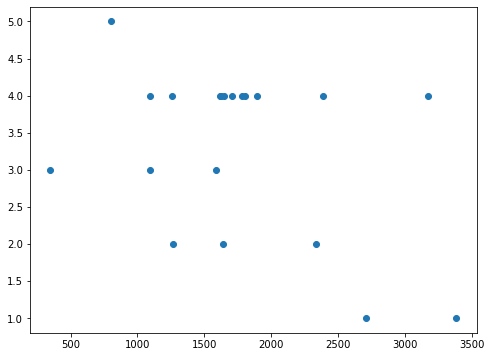

In [75]:
# Let's plot it with scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x=user_id_data['MovieID'], y=user_id_data['Rating'])
plt.show()

In [76]:
# Obtain unique genres
Master_Data['Genre'].unique()

array(['Drama', "Animation|Children's|Musical", 'Musical|Romance',
       "Animation|Children's|Comedy", 'Action|Adventure|Comedy|Romance',
       'Action|Adventure|Drama', 'Comedy|Drama',
       "Adventure|Children's|Drama|Musical", 'Musical', 'Comedy',
       "Animation|Children's", 'Comedy|Fantasy', 'Animation',
       'Comedy|Sci-Fi', 'Drama|War', 'Romance',
       "Animation|Children's|Musical|Romance",
       "Children's|Drama|Fantasy|Sci-Fi", 'Drama|Romance',
       'Animation|Comedy|Thriller',
       "Adventure|Animation|Children's|Comedy|Musical",
       "Animation|Children's|Comedy|Musical", 'Thriller',
       'Action|Crime|Romance', 'Action|Adventure|Fantasy|Sci-Fi',
       "Children's|Comedy|Musical", 'Action|Drama|War',
       "Children's|Drama", 'Crime|Drama|Thriller', 'Action|Crime|Drama',
       'Action|Adventure|Mystery', 'Crime|Drama',
       'Action|Adventure|Sci-Fi|Thriller',
       'Action|Adventure|Romance|Sci-Fi|War', 'Action|Thriller',
       'Action|Drama', 'Co

In [77]:
Master_Data['Genre'] = Master_Data['Genre'].apply(lambda x : x.split('|')[0])

In [78]:
Master_Data.head()

,UserId,MovieID,Rating,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code,Release Year
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama,F,1.0,10.0,48067,1975
1,1.0,661,3.0,978302109.0,James and the Giant Peach (1996),Animation,F,1.0,10.0,48067,1996
2,1.0,914,3.0,978301968.0,My Fair Lady (1964),Musical,F,1.0,10.0,48067,1964
3,1.0,3408,4.0,978300275.0,Erin Brockovich (2000),Drama,F,1.0,10.0,48067,2000
4,1.0,2355,5.0,978824291.0,"Bug's Life, A (1998)",Animation,F,1.0,10.0,48067,1998


In [79]:
# Enconding. That is converting categorical data to numerical data to enable analysis
'''
There are a couple of ways we can do it. We sklearn encoder or the dummy() function from pandas
Let's delete timestamp and title column from the data
'''
del Master_Data['Timestamp']
del Master_Data['Title']

#Check if we need to keep zip code
del Master_Data['Zip Code']

In [80]:
Master_Data.head()

,UserId,MovieID,Rating,Genre,Gender,Age,Occupation,Release Year
0,1.0,1193,5.0,Drama,F,1.0,10.0,1975
1,1.0,661,3.0,Animation,F,1.0,10.0,1996
2,1.0,914,3.0,Musical,F,1.0,10.0,1964
3,1.0,3408,4.0,Drama,F,1.0,10.0,2000
4,1.0,2355,5.0,Animation,F,1.0,10.0,1998


In [81]:
#Master_DataN = pd.get_dummies(Master_Data)

In [82]:
#Master_DataN.head()

# Modeling the data

In [83]:
df.head()

,UserId,MovieID,Rating,Timestamp,Title,Genre,Gender,Age,Occupation,Zip Code,Release Year,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6
0,1.0,1193,5.0,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama,F,Under 18,K-12 student,48067,1975,Drama,None,None,None,None,None
1,1.0,661,3.0,978302109.0,James and the Giant Peach (1996),Animation|Children's|Musical,F,Under 18,K-12 student,48067,1996,Animation,Children's,Musical,None,None,None
2,1.0,914,3.0,978301968.0,My Fair Lady (1964),Musical|Romance,F,Under 18,K-12 student,48067,1964,Musical,Romance,None,None,None,None
3,1.0,3408,4.0,978300275.0,Erin Brockovich (2000),Drama,F,Under 18,K-12 student,48067,2000,Drama,None,None,None,None,None
4,1.0,2355,5.0,978824291.0,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,Under 18,K-12 student,48067,1998,Animation,Children's,Comedy,None,None,None


In [84]:
# We can drop or delete from the data some of the columns that might not be useful
# Let's just take the data we have already removed these guys
df1 = Master_Data
df1.head(2)

,UserId,MovieID,Rating,Genre,Gender,Age,Occupation,Release Year
0,1.0,1193,5.0,Drama,F,1.0,10.0,1975
1,1.0,661,3.0,Animation,F,1.0,10.0,1996


In [85]:
df1.isnull().sum()

UserId          177
MovieID           0
Rating          177
Genre             0
Gender          177
Age             177
Occupation      177
Release Year      0
dtype: int64

In [86]:
#df1['UserId'] = df1['UserId'].astype(str)
df1['Gender']=LabelEncoder().fit_transform(df1['Gender'])
df1['Genre']=LabelEncoder().fit_transform(df1['Genre']) #See below

In [87]:
# Replace the NaNs with their averages
df1.UserId=df1.UserId.fillna(df1.UserId.mean())
df1.Rating=df1.Rating.fillna(df1.Rating.mean())
df1.Age=df1.Age.fillna(df1.Age.mean())
df1.Occupation=df1.Occupation.fillna(df1.Occupation.mean())
df1.Gender=df1.Gender.fillna(df1.Gender.mean())
#df1['Zip Code'] =df1['Zip Code'] .fillna(df1['Zip Code'].mean())

In [88]:
df1.isnull().sum()

UserId          0
MovieID         0
Rating          0
Genre           0
Gender          0
Age             0
Occupation      0
Release Year    0
dtype: int64

## Frequency encoding

In [89]:
for c in ['UserId', 'MovieID', 'Occupation', 'Release Year']:
    print(f"Frequency Encoding: {c} - {df1[c].nunique()}")
    freq = df1[c].value_counts()
    df1[c] = df1[c].apply(lambda x: freq[x])

Frequency Encoding: UserId - 6041
Frequency Encoding: MovieID - 3883
Frequency Encoding: Occupation - 22
Frequency Encoding: Release Year - 81


## Label encoder

In [90]:
for c in ['Gender', 'Age', 'Genre', 'Rating']:
    print(f"Label Encoding: {c} - {df1[c].nunique()}")
    le = LabelEncoder()
    df1[c] = le.fit_transform(df1[c]) #Loop over, same as "LabelEncoder().fit_transform(df1['Gender'])" for single entry

Label Encoding: Gender - 3
Label Encoding: Age - 8
Label Encoding: Genre - 18
Label Encoding: Rating - 6


In [91]:
df1.shape

(1000386, 8)

In [92]:
'''
If we want to keep the title in the modeling, we can do the following below


from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(max_features = 8, analyzer = 'word', stop_words = 'english', 
                      binary = False, ngram_range = (1, 2))
title_vectors = pd.DataFrame(tfid.fit_transform(df['Title']).toarray(), 
                          columns = ['nc_{}'.format(i) for i in range(8)])
title_vectors.head()
'''

"\nIf we want to keep the title in the modeling, we can do the following below\n\n\nfrom nltk.corpus import stopwords\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\ntfid = TfidfVectorizer(max_features = 8, analyzer = 'word', stop_words = 'english', \n                      binary = False, ngram_range = (1, 2))\ntitle_vectors = pd.DataFrame(tfid.fit_transform(df['Title']).toarray(), \n                          columns = ['nc_{}'.format(i) for i in range(8)])\ntitle_vectors.head()\n"

## We will run the model on 70/30

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop('Rating', axis = 1), df1['Rating'].values.ravel(), 
                                                  test_size = 0.3, stratify = df1['Rating'],random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700270, 7), (300116, 7), (700270,), (300116,))

In [94]:
X_train.dtypes

UserId          int64
MovieID         int64
Genre           int64
Gender          int64
Age             int64
Occupation      int64
Release Year    int64
dtype: object

In [95]:
X_train.dtypes

UserId          int64
MovieID         int64
Genre           int64
Gender          int64
Age             int64
Occupation      int64
Release Year    int64
dtype: object

In [96]:
X_train.isnull().sum()

UserId          0
MovieID         0
Genre           0
Gender          0
Age             0
Occupation      0
Release Year    0
dtype: int64

In [97]:
params = {
          "objective" : "multiclass",
          "num_class" : 6,
          "num_leaves" : 100,
          "max_depth": -1,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2021,
          "verbosity" : -1 }

In [98]:
ltrain = lgbm.Dataset(X_train, y_train) 
lvalid = lgbm.Dataset(X_test, y_test)

clf = lgbm.train(params, ltrain, 20000, valid_sets = [ltrain, lvalid],
                 early_stopping_rounds = 100, verbose_eval = 500) #This is our model
#preds = clf.predict(X_test) 
#print(classification_report(y_test, np.argmax(preds, axis = 1)))

Training until validation scores don't improve for 100 rounds
[500]	training's multi_logloss: 1.29741	valid_1's multi_logloss: 1.30894
[1000]	training's multi_logloss: 1.26603	valid_1's multi_logloss: 1.28972
[1500]	training's multi_logloss: 1.24427	valid_1's multi_logloss: 1.27947
[2000]	training's multi_logloss: 1.22647	valid_1's multi_logloss: 1.27262
[2500]	training's multi_logloss: 1.21069	valid_1's multi_logloss: 1.26744
[3000]	training's multi_logloss: 1.19659	valid_1's multi_logloss: 1.2634
[3500]	training's multi_logloss: 1.18358	valid_1's multi_logloss: 1.26018
[4000]	training's multi_logloss: 1.17122	valid_1's multi_logloss: 1.25738
[4500]	training's multi_logloss: 1.15963	valid_1's multi_logloss: 1.25506
[5000]	training's multi_logloss: 1.14845	valid_1's multi_logloss: 1.25303
[5500]	training's multi_logloss: 1.13783	valid_1's multi_logloss: 1.25122
[6000]	training's multi_logloss: 1.12781	valid_1's multi_logloss: 1.24985
[6500]	training's multi_logloss: 1.11803	valid_1's m

In [99]:
preds = clf.predict(X_test)

In [100]:
####
print(classification_report(y_test, np.argmax(preds, axis = 1)))

              precision    recall  f1-score   support

           0       0.49      0.26      0.34     16852
           1       0.36      0.11      0.17     32267
           2       0.41      0.37      0.39     78359
           3       1.00      1.00      1.00        53
           4       0.44      0.64      0.52    104692
           5       0.53      0.45      0.48     67893

    accuracy                           0.45    300116
   macro avg       0.54      0.47      0.48    300116
weighted avg       0.44      0.45      0.43    300116



In [101]:
shap.initjs()

In [102]:
explainer_1 = shap.TreeExplainer(clf)
shap_values_1 = explainer_1.shap_values(X_test)

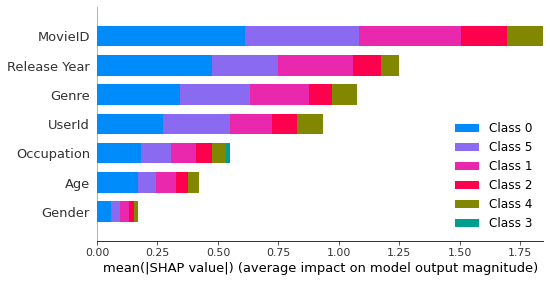

In [103]:
# Plot and display
shap.summary_plot(shap_values_1, X_test)

In [104]:
params = {
     'eta': 0.2,  
     'objective': 'multi:softprob',  # error evaluation for multiclass tasks
     'num_class': 6,  # number of classes to predic
     'colsample_bytree': 0.55,
     'subsample': 0.7,
     'learning_rate': 0.015,
     'max_depth': 9,
     'seed': 2020, 
     'min_child_weight': 257
    }

num_round = 1500

y_train = y_train.astype(float) 
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)


xtrain = xgb.DMatrix(X_train, label = y_train)
xvalid = xgb.DMatrix(X_test, label = y_test)

model = xgb.train(params, xtrain, num_round, verbose_eval = 500,
                  evals = [(xtrain, 'train'), (xvalid, 'valid')],
                  early_stopping_rounds = 100)

#plot_importance(model)

[04:04:30] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.78622	valid-mlogloss:1.78622
[500]	train-mlogloss:1.32909	valid-mlogloss:1.33649
[1000]	train-mlogloss:1.30659	valid-mlogloss:1.31732
[1499]	train-mlogloss:1.29617	valid-mlogloss:1.30907


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

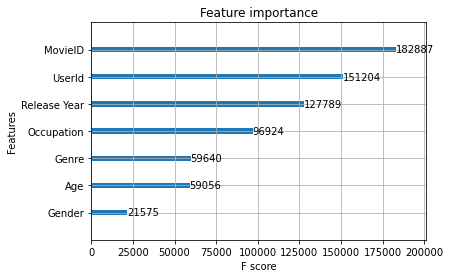

In [105]:
# Plot model
plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

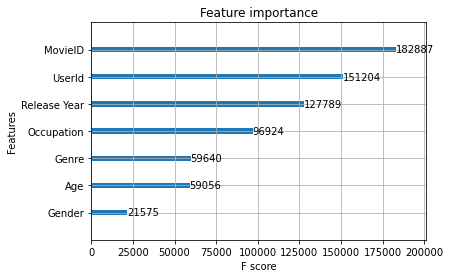

In [106]:
## Check also
xgb.plot_importance(model)

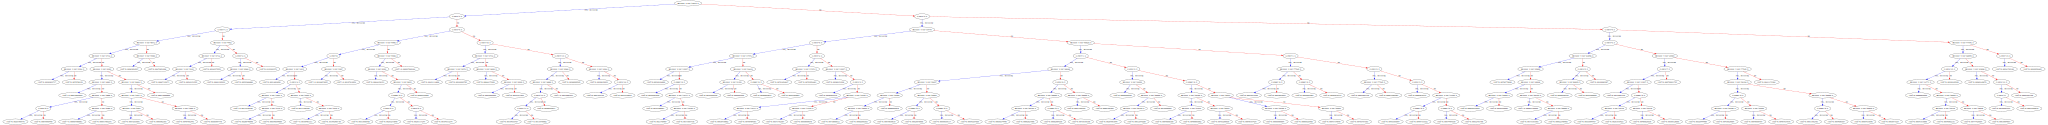

In [107]:
xgb.to_graphviz(model, num_trees=2)

In [108]:
xpreds = model.predict(xvalid)
print(np.argmax(xpreds, axis = 1))

[4 4 4 ... 2 2 4]


In [109]:
print(classification_report(y_test, np.argmax(xpreds, axis = 1)))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

         0.0       0.47      0.13      0.20     16852
         1.0       0.36      0.03      0.06     32267
         2.0       0.37      0.33      0.35     78359
         3.0       0.00      0.00      0.00        53
         4.0       0.41      0.69      0.51    104692
         5.0       0.51      0.35      0.41     67893

    accuracy                           0.42    300116
   macro avg       0.35      0.25      0.25    300116
weighted avg       0.42      0.42      0.38    300116



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Use shape to also analyze with the second model

In [110]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

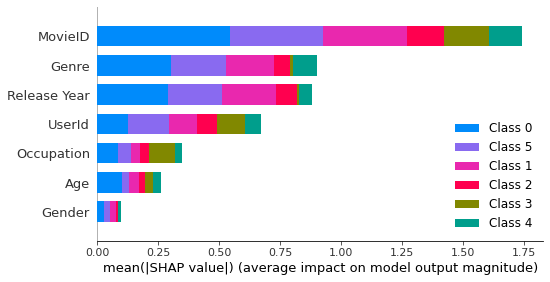

In [111]:
# Plot and display
shap.summary_plot(shap_values, X_test)

In [112]:
### Save the model trained with xgboost
model.save_model('Testmodel.model')

In [114]:
## # dump model
#model.dump_model('dump.raw.txt')
# dump model with feature map
#model.dump_model('dump.raw.txt', 'featmap.txt')

In [ ]:
# Load a saved model
#model = xgb.Booster({'nthread': 4})  # init model
#model.load_model('Testmodel.model')  # load data